<a href="https://colab.research.google.com/github/boyu571/AIVILL/blob/main/PointCloudClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


In [ ]:
tf.random.set_seed(1234)

### Load dataset
ModelNet10 model dataset, the samller 10 class version of the ModelNet40 dataset.

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 12s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

mesh파일을 point cloud로 바꾸기 위해 mesh 표면에서 sample point를 추출해야한다. .sample() 함수는 균일한 랜덤 샘플링을 수행한다. 다음은 2048개의 샘플 포인트를 시각화한 것이다.

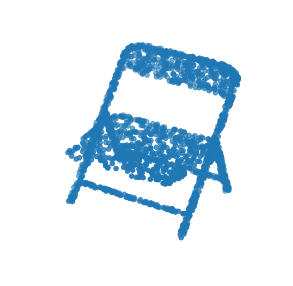

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

tf.data.Dataset()을 수행하기 위해 우선 ModelNet 데이터 폴더를 불러와야한다. Mesh는 파이썬 리스트로 추가하여 numpy array로 전환하여 불러와 point cloud로 sample해야 한다. 또한 딕셔너리 형태로 객체 레이블을 enumerate index 값으로 저장하여 추후에 불러올 수 있어야 한다.

In [ ]:
def parse_dataset(num_points = 2048):
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map = {}
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

  for i, folder in enumerate(folders):
    print('processing class: {}'.format(os.path.basename(folder)))
    # store folder name with ID so we can retrieve later
    class_map[i] = folder.split('/')[-1]
    # gather all files
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
        train_points.append(trimesh.load(f).sample(num_points))
        train_labels.append(i)

    for f in test_files:
        test_points.append(trimesh.load(f).sample(num_points))
        test_labels.append(i)

  return (
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )

포인드 수와 배치 사이즈를 설정한 후 데이터셋을 불러온다. 약 5분 이상 소요됨

In [ ]:
NUM_POINTS = 2048 # 포인트 수
NUM_CLASSES = 10  # 클래스 수
BATCH_SIZE = 32   # 배치사이즈 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: toilet
processing class: table
processing class: monitor
processing class: dresser
processing class: night_stand
processing class: bathtub
processing class: desk
processing class: sofa
processing class: chair
processing class: bed


이제 tf.data.Dataset() 함수로 데이터를 불러올 수 있다. 이 데이터를 클래스별로 order하기 전에 우선 suffle buffer size를 데이터셋의 크기 만큼으로 설정한다. point cloud data로 작업할 경우 데이터를 증강하는 것은 중요하다. 다음은 jitter 증강 함수를 만들고 훈련 데이터셋을 섞는다.

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

#### Build a model

각 convolution and fully-connected layer (with exception for end layers) consists of Convolution / Dense - > Batch Normalization -> ReLU Activation
각 Conv & FC Layer(마지막 레이어를 제외하고)는 Convolution / Dense - > Batch Normalization -> ReLU Activation로 구성됨</br></br>

Conv1D or Dense </br>
BatchNormalization(momentum = 0.0)</br>
Activation("relu")</br></br>

Dense()</br>
BatchNormalization(momentum = 0.0)</br>
Activation("relu")</br>

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet은 두 개의 핵심 컴포넌트로 구성돼있음. 첫 번째는 MLP 네트워크, 두 번째는 transformer net(T-net)이다. T-net은 affine transformation matrix를 위한 작은 네트워크이다. T-net은 두 번사용된다. 첫 번쨰에는 input features (n, 3)을 canonical representation로 transform하기 위해 사용되고, 두 번째는 특징 공간(feature space) (n, 3)에서 데이터를 정렬하기 위해 affine transformation을 수행하기 위함이다. 원 논문에 따라서 여기서 transformation을 직교 행렬(orthogonal matrix)에 가깝게 제한합니다. 

</br> || X * X^T - I || = 0 </br>
X* X^T = X^T * X = I

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer): # 직교 행렬
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

General function을 정의하고 T-net layer 를 만든다.

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. 

원 논문에서 제시한 모델을 따라하되 10개의 클래스를 가진 ModelNet dataset에 맞게 각 레이어의 weight를 절반으로 줄인다.


In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

### Train model

모델을 정의하고 일반적인 모델처럼 `.compile()`이나 `.fit()`으로 훈련시킨다.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 37s 164ms/step - loss: 3.5675 - sparse_categorical_accuracy: 0.2591 - val_loss: 82463521264937656647680.0000 - val_sparse_categorical_accuracy: 0.3304
Epoch 2/20
125/125 [==============================] - 20s 160ms/step - loss: 2.9342 - sparse_categorical_accuracy: 0.4049 - val_loss: 330637747986660065280.0000 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/20
125/125 [==============================] - 20s 163ms/step - loss: 2.6832 - sparse_categorical_accuracy: 0.5079 - val_loss: 10552325701632.0000 - val_sparse_categorical_accuracy: 0.4659
Epoch 4/20
125/125 [==============================] - 21s 166ms/step - loss: 2.5149 - sparse_categorical_accuracy: 0.5573 - val_loss: 30532815579758198784.0000 - val_sparse_categorical_accuracy: 0.4890
Epoch 5/20
125/125 [==============================] - 21s 169ms/step - loss: 2.3821 - sparse_categorical_accuracy: 0.5898 - val_loss: 346193184.0000 - val_sparse_categorical_accuracy: 0.5650
Epo

## Visualize predictions

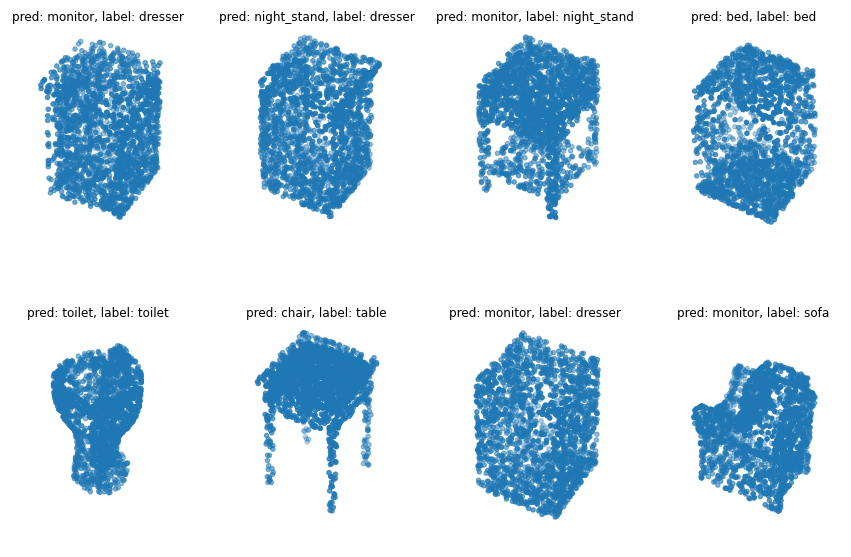

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()